In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

luminex = pd.read_csv("../data/UpdatedLuminex.csv")
metadata = pd.read_csv("../data/Metadata_v2.csv")
df = pd.read_csv("../data/merged_filtered.csv")

In [3]:


# data cleaning and preprocessing / feature engineering
df["Thal (n)"] = df["Thal"].str.split(" ").str[1].astype(int)

df["ABeta ratio"] = df["ABeta42 pg/ug"] / df["ABeta40 pg/ug"]
df["TAU ratio"] = df["pTAU pg/ug"] / df["tTAU pg/ug"]
education_order = [
    "High School",
    "Trade School/ Tech School",
    "Bachelors",
    "Graduate (PhD/Masters)",
    "Professional",
]
df["Highest level of education"] = pd.Categorical(
    df["Highest level of education"], categories=education_order, ordered=True
)
# condense into 2 groups, high school and post-secondary
df["Post-secondary"] = pd.Categorical(df["Highest level of education"].apply(
    lambda x: "High School" if x == "High School" else "Post-Secondary"
), categories=["High School", "Post-Secondary"], ordered=True)
# condense into 2 groups, e4+ and e4-
df["APOE Genotype 4"] = df["APOE Genotype"].apply(
    lambda x: "e4+" if "4" in x else "e4-"
)

In [4]:
# define x and y for analysis
x_anova = "Highest level of education"
x_lin_reg = "Years of education"
x_t = "Post-secondary"
y = "TAU ratio"

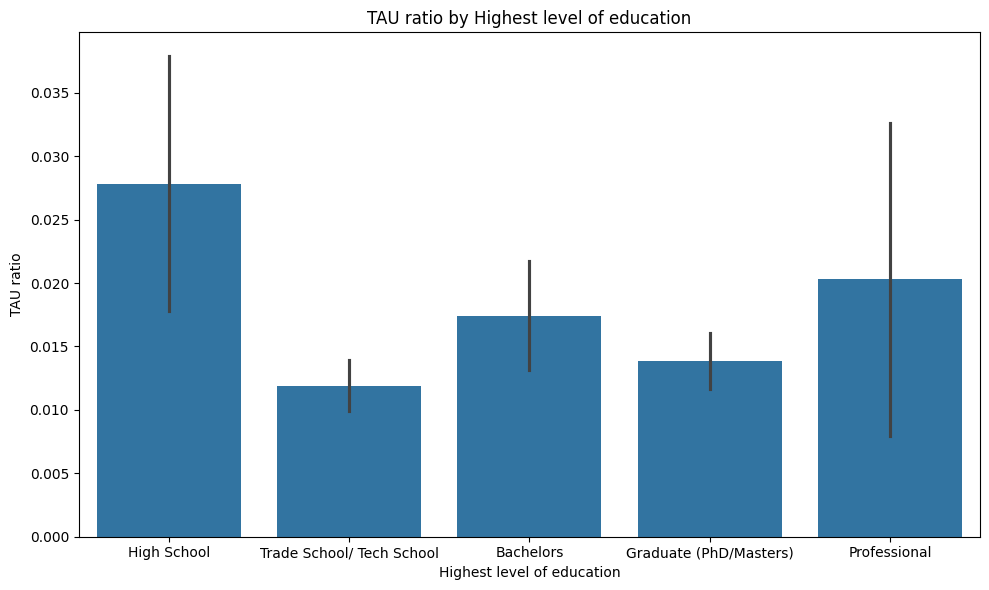

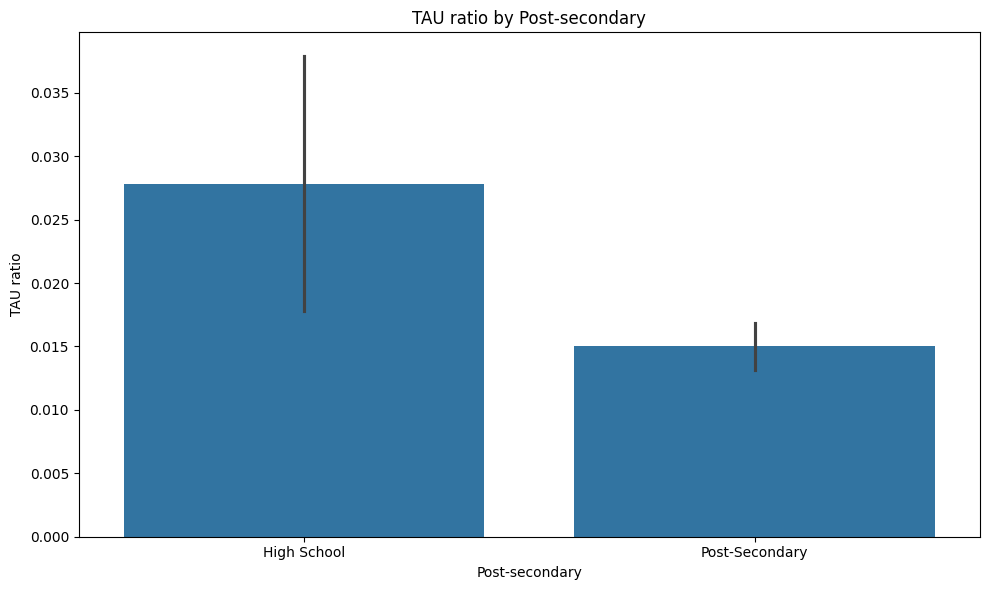

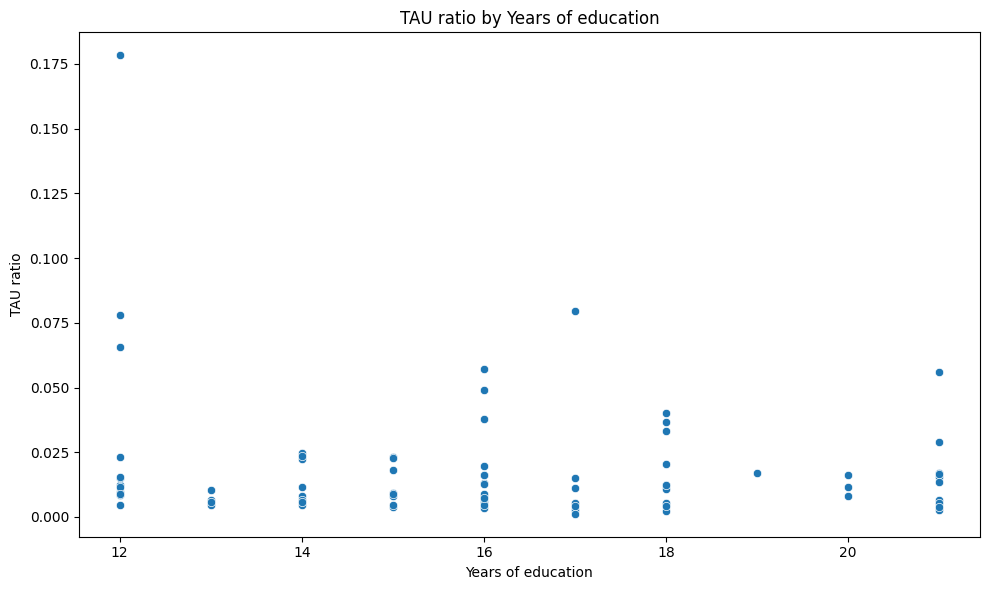

In [5]:
# initial visualization
# bar plot multiple groups
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=x_anova, y=y, errorbar="se")
plt.ylabel(y)
plt.xlabel(x_anova)
plt.title(f"{y} by {x_anova}")
plt.tight_layout()
plt.show()

# bar plot two groups
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=x_t, y=y, errorbar="se")
plt.ylabel(y)
plt.xlabel(x_t)
plt.title(f"{y} by {x_t}")
plt.tight_layout()

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=x_lin_reg, y=y)
plt.ylabel(y)
plt.xlabel(x_lin_reg)
plt.title(f"{y} by {x_lin_reg}")
plt.tight_layout()
plt.show()

In [6]:
# run ANOVA for every group in x
try:
    model = ols(f'Q("{y}") ~ Q("{x_anova}")', data=df).fit()
except Exception as e:
    print("likely bad columns specified")
    print(f"Error in model fitting: {e}")
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                   sum_sq    df        F    PR(>F)
Q("Highest level of education")  0.002729   4.0  1.18528  0.323886
Residual                         0.044895  78.0      NaN       NaN


In [7]:
# run Tukey's HSD test for post-hoc analysis (anova)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df[y], groups=df[x_anova], alpha=0.05)
print(tukey)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2          meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------------------------
             Bachelors    Graduate (PhD/Masters)  -0.0036 0.9867 -0.0233 0.0162  False
             Bachelors               High School   0.0104 0.6523 -0.0109 0.0317  False
             Bachelors              Professional   0.0029 0.9995 -0.0335 0.0393  False
             Bachelors Trade School/ Tech School  -0.0055 0.9593 -0.0279 0.0169  False
Graduate (PhD/Masters)               High School    0.014 0.3431 -0.0069 0.0349  False
Graduate (PhD/Masters)              Professional   0.0064 0.9874 -0.0297 0.0426  False
Graduate (PhD/Masters) Trade School/ Tech School  -0.0019 0.9992  -0.024 0.0201  False
           High School              Professional  -0.0075 0.9794 -0.0446 0.0295  False
           High School Trade School/ Tech S

In [8]:
# t-test between the two groups

group1_name = "High School"
group2_name = "Post-Secondary"

group1 = df[df[x_t] == group1_name][y].dropna()
group2 = df[df[x_t] == group2_name][y].dropna()

t_stat, p_value = stats.ttest_ind(group1, group2)
print(
    f"T-test between {group1_name} and {group2_name} for {y}: t-statistic = {t_stat}, p-value = {p_value}"
)

T-test between High School and Post-Secondary for TAU ratio: t-statistic = 2.033778045320868, p-value = 0.04524761826063113


In [9]:
# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df[x_lin_reg].dropna(), df[y].dropna()
)
print(
    f"Linear regression of {y} on {x_lin_reg}: \nslope = {slope}, intercept = {intercept}, r-squared = {r_value**2}, p-value = {p_value}"
)

Linear regression of TAU ratio on Years of education: 
slope = -0.0013376768538759139, intercept = 0.039413867872595126, r-squared = 0.023732396194147652, p-value = 0.16437011341399876


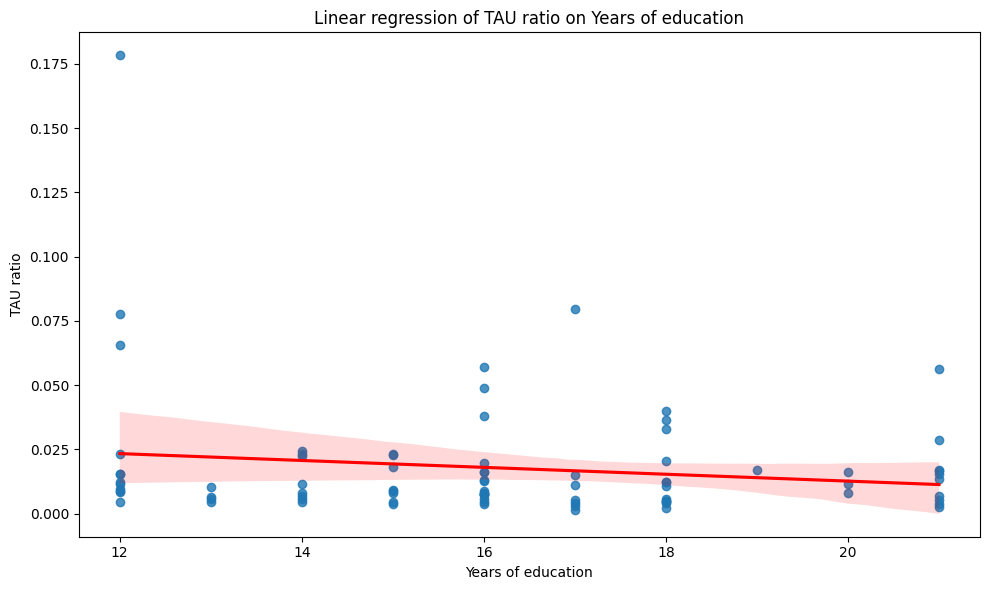

In [10]:
# graph linear regression
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x=x_lin_reg, y=y, line_kws={"color": "red"})
plt.ylabel(y)
plt.xlabel(x_lin_reg)
plt.title(f"Linear regression of {y} on {x_lin_reg}")
plt.tight_layout()
plt.show()

In [11]:
cols_to_drop = [
    "Donor ID",
    "Primary Study Name",
    "Secondary Study Name",
    "Age at Death",
    "Cognitive Status",
    "Age of onset cognitive symptoms",
    "Age of Dementia diagnosis",
    "Known head injury",
    "Have they had neuroimaging",
    "Consensus Clinical Dx (choice=Alzheimers disease)",
    "Consensus Clinical Dx (choice=Alzheimers Possible/ Probable)",
    "Consensus Clinical Dx (choice=Ataxia)",
    "Consensus Clinical Dx (choice=Corticobasal Degeneration)",
    "Consensus Clinical Dx (choice=Control)",
    "Consensus Clinical Dx (choice=Dementia with Lewy Bodies/ Lewy Body Disease)",
    "Consensus Clinical Dx (choice=Frontotemporal lobar degeneration)",
    "Consensus Clinical Dx (choice=Huntingtons disease)",
    "Consensus Clinical Dx (choice=Motor Neuron disease)",
    "Consensus Clinical Dx (choice=Multiple System Atrophy)",
    "Consensus Clinical Dx (choice=Parkinsons disease)",
    "Consensus Clinical Dx (choice=Parkinsons Cognitive Impairment - no dementia)",
    "Consensus Clinical Dx (choice=Parkinsons Disease Dementia)",
    "Consensus Clinical Dx (choice=Prion)",
    "Consensus Clinical Dx (choice=Progressive Supranuclear Palsy)",
    "Consensus Clinical Dx (choice=Taupathy)",
    "Consensus Clinical Dx (choice=Vascular Dementia)",
    "Consensus Clinical Dx (choice=Unknown)",
    "Consensus Clinical Dx (choice=Other)",
    "If other Consensus dx, describe",
    "Last CASI Score",
    "Interval from last CASI in months",
    "Last MMSE Score",
    "Interval from last MMSE in months",
    "Last MOCA Score",
    "Interval from last MOCA in months",
    "PMI",
    "Rapid Frozen Tissue Type",
    "Ex Vivo Imaging",
    "Fresh Brain Weight",
    "Brain pH",
    "Overall AD neuropathological Change",
    "Thal",
    "Braak",
    "CERAD score",
    "Overall CAA Score",
    "Highest Lewy Body Disease",
    "Total Microinfarcts (not observed grossly)",
    "Total microinfarcts in screening sections",
    "Atherosclerosis",
    "Arteriolosclerosis",
    "LATE",
    "RIN",
    "Severely Affected Donor",
    "Thal (n)"
]

In [12]:
# random forest regression using all features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# select features and target
features = df.drop(columns=cols_to_drop)
target = df[y]
# one-hot encode categorical variables
features = pd.get_dummies(features, drop_first=True)
# split into training and testing sets, set seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# train the model
rf = RandomForestRegressor(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)
# make predictions
y_pred = rf.predict(X_test)
# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Regressor MSE: {mse}, R2: {r2}")
# feature importance
feature_names = features.columns
feature_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Feature importances:")
print(feature_importances.head(20))

Random Forest Regressor MSE: 0.000814788331182572, R2: 0.5080913894301209
Feature importances:
TAU ratio                                            0.831365
pTAU pg/ug                                           0.130845
ABeta42 pg/ug                                        0.004568
ABeta40 pg/ug                                        0.004341
Race (choice=Asian)_Unchecked                        0.004071
Post-secondary_Post-Secondary                        0.003755
Years of education                                   0.003622
ABeta ratio                                          0.003288
tTAU pg/ug                                           0.003096
Sex_Male                                             0.002947
APOE Genotype_4/4                                    0.002021
Race (choice=White)_Unchecked                        0.001847
Highest level of education_Graduate (PhD/Masters)    0.001245
Highest level of education_Bachelors                 0.000969
APOE Genotype_3/3                    

In [13]:
# now drop obvious correlated features and rerun
cols_to_drop_2 = cols_to_drop + [
    "pTAU pg/ug",
    "tTAU pg/ug",
    "ABeta ratio",
    "ABeta40 pg/ug",
    "ABeta42 pg/ug",
    "TAU ratio",
    "ABeta ratio",
]
# select features and target
features = df.drop(columns=cols_to_drop_2)
target = df[y]
# one-hot encode categorical variables
features = pd.get_dummies(features, drop_first=True)
# split into training and testing sets, set seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)
# train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# make predictions
y_pred = rf.predict(X_test)
# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Regressor MSE: {mse}, R2: {r2}")
# feature importance
feature_names = features.columns
feature_importances = pd.Series(
    rf.feature_importances_, index=feature_names
).sort_values(ascending=False)
print("Feature importances:")
print(feature_importances.head(20))

Random Forest Regressor MSE: 0.002080198785463466, R2: -0.2558693529414293
Feature importances:
Years of education                                        0.187683
Hispanic/Latino_Unknown                                   0.153896
Race (choice=White)_Unchecked                             0.145914
Sex_Male                                                  0.132796
Race (choice=Asian)_Unchecked                             0.065445
Highest level of education_Professional                   0.064743
Highest level of education_Bachelors                      0.054889
APOE Genotype_4/4                                         0.035967
APOE Genotype 4_e4-                                       0.033359
APOE Genotype_3/3                                         0.032704
APOE Genotype_3/4                                         0.025019
Highest level of education_Graduate (PhD/Masters)         0.023229
Highest level of education_Trade School/ Tech School      0.014513
APOE Genotype_2/3                

In [ ]:
# ALSO: just to show a good linear regression example (for credit)

df_copy_lin_reg = df.copy()
x_lin_reg_cred = "Age of Dementia diagnosis"
y_lin_reg_cred = ""

# remove NaN rows for the two columns of interest
df_copy_lin_reg = df_copy_lin_reg[
    df_copy_lin_reg[x_lin_reg_cred].notna() & df_copy_lin_reg[y_lin_reg_cred].notna()
]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_copy_lin_reg[x_lin_reg_cred].dropna(), df_copy_lin_reg[y_lin_reg_cred].dropna()
)
print(
    f"Linear regression of {y_lin_reg_cred} on {x_lin_reg_cred}: \nslope = {slope}, intercept = {intercept}, r-squared = {r_value**2}, p-value = {p_value}"
)

Linear regression of Thal (n) on Age of Dementia diagnosis: 
slope = -0.025888160794569657, intercept = 6.278525462078693, r-squared = 0.08030799176061927, p-value = 0.09396470663142086


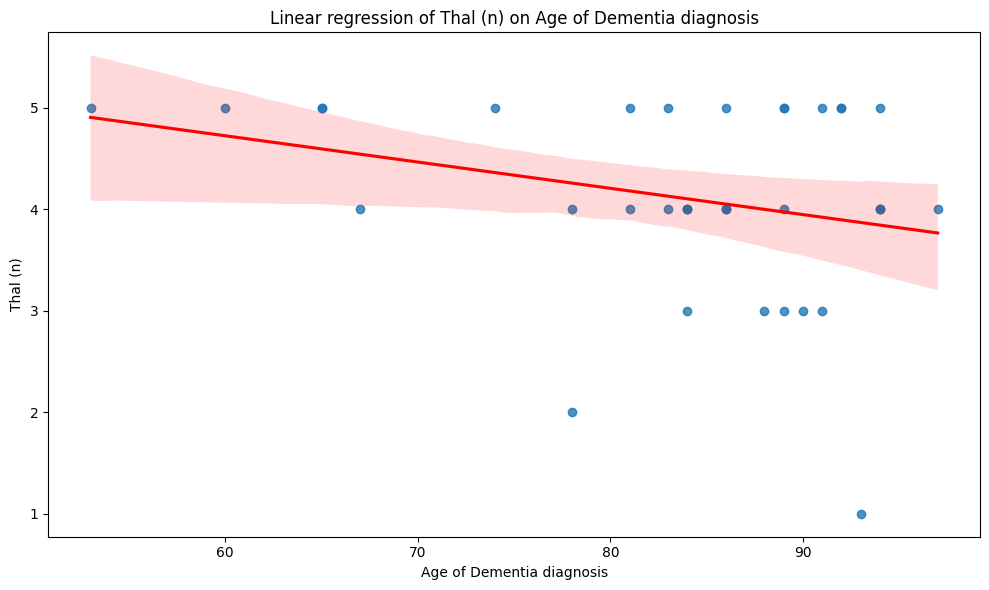

In [15]:
# graph
plt.figure(figsize=(10, 6))
sns.regplot(data=df_copy_lin_reg, x=x_lin_reg_cred, y=y_lin_reg_cred, line_kws={"color": "red"})
plt.ylabel(y_lin_reg_cred)
plt.xlabel(x_lin_reg_cred)
plt.title(f"Linear regression of {y_lin_reg_cred} on {x_lin_reg_cred}")
plt.tight_layout()
plt.show()